In [1]:
import sys
import os
import time
import json
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.spatial import ConvexHull
from scipy.spatial.qhull import QhullError
import pandas as pd
from operator import itemgetter
from itertools import chain
from collections import Counter
from tqdm.notebook import tqdm
from ipywidgets import interact
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

import string
from nltk.corpus import stopwords
from transformers import BertTokenizer

import matplotlib.pyplot as plt

from bert_serving.client import BertClient

import torch
from torch.utils.tensorboard import SummaryWriter

from config import *

In [2]:
INVALID_TOKENS = set(stopwords.words('english') + list(string.punctuation))
TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased')

### Visualization

In [3]:
def make_pytorch_projector(log_dir, mat, labels=None):
    '''Exports PyTorch projector'''
    writer = SummaryWriter(log_dir)
    writer.add_embedding(mat, metadata=labels)
    writer.close()

def project_pca(document_embs, summary_embs):
    pca = PCA(n_components=2)
    document_pts = pca.fit_transform(document_embs)
    summary_pts = list(map(pca.transform, summary_embs))
    return document_pts, summary_pts

def project_tsne(document_embs, summary_embs):
    n = np.cumsum([0] + list(map(len,summary_embs)))
    embs = document_embs + list(chain(*summary_embs))
    tsne = TSNE(n_iter=3000, perplexity=30, verbose=1)
    pts = tsne.fit_transform(embs)
    return pts[:len(document_embs)], [pts[i:j] for i,j in zip(n[:-1], n[1:])]

### Preprocessing

In [4]:
def valid_tokens(sentence):
    '''Outputs valid tokens in a sentence.
    
    Input:  list of tokens
    Output: list of valid tokens
    '''
    return list(filter(lambda token: token not in INVALID_TOKENS, sentence))

def tokenize_document(document):
    '''Tokenizes every sentence in a document.
    
    Input:  list of str
    Output: list of list of tokens
    '''
    return list(map(TOKENIZER.tokenize, document))

def filter_document(document):
    '''Filters every sentence in a document (extract valid tokens).
    
    Input:  list of list of tokens
    Output: list of list of valid tokens
    '''
    return list(map(valid_tokens, document))

def preprocess(document):
    '''Preprocesses a list of sentences.
    
    Input:  list of str
    Output: list of list of valid tokens
    '''
    return filter_document(tokenize_document(document))

### Metrics

In [5]:
def number_of_repeating_words(summary):
    '''Counts the number of repeating words in a summary'''
    cnt = Counter(chain(*preprocess(summary)))
    return len([cnt[k] for k in cnt if cnt[k] > 1])

def distance_to_subspace(v, S):
    '''Calculates a distance from vector to subspace'''
    return np.linalg.norm(v - (v @ S.T) @ S)

def average_distance_between_vectors(S):
    '''Calculates the average distance between vectors'''
    return np.mean([np.mean(np.linalg.norm(si - S, axis=1)) for si in S])

def naive(documents, summaries):
    scores = []
    for summary in summaries:
        scores.append(number_of_repeating_words(summary))
    return np.array(scores)

def average_distance(document_embs, summary_embs):
    scores = []
    for summary in summary_embs:
        S = np.array(summary)
        scores.append(average_distance_between_vectors(S))
    return np.array(scores)

def semantic_volume(document_embs, summary_embs, normalize=False):
    scores = []
    document_hull = ConvexHull(document_embs)
    for summary in summary_embs:
        try:
            summary_hull = ConvexHull(summary)
            scores.append(summary_hull.volume / (document_hull.volume if normalize else 1))
        except QhullError: # Not enough points
            scores.append(0)
    return np.array(scores)

# Main

## Use-case

1. Take the documents, summaries, and pyramid scores for one topic
2. Embed the documents and summaries (or load embeddings) using bert-as-service (unmodif)
3. Calculate score for summaries
4. Compute correlation with human judgements
5. Export TensorBoard projector

In [6]:
DATASET = DATASETS[0]
TOPIC = 'D0841'

## Get embeddings

In [7]:
# bc = BertClient(output_fmt='list') # The tokenizer might be different from the Huggingface's one

In [8]:
with open(os.path.join(DATA_DIR, DATASET + '.json')) as fp:
    tac = json.load(fp)
tac.keys()

dict_keys(['D0841', 'D0804', 'D0802', 'D0809', 'D0819', 'D0825', 'D0828', 'D0826', 'D0843', 'D0829', 'D0813', 'D0807', 'D0812', 'D0820', 'D0835', 'D0823', 'D0847', 'D0848', 'D0810', 'D0822', 'D0845', 'D0844', 'D0839', 'D0814', 'D0824', 'D0821', 'D0827', 'D0846', 'D0818', 'D0834', 'D0805', 'D0817', 'D0831', 'D0815', 'D0836', 'D0806', 'D0808', 'D0837', 'D0803', 'D0830', 'D0838', 'D0840', 'D0842', 'D0832', 'D0816', 'D0801', 'D0833', 'D0811'])

In [9]:
topic = tac[TOPIC]

documents = topic['documents']
annotations = topic['annotations']

summaries = list(map(itemgetter('text'), annotations))
pyr_scores = list(map(itemgetter('pyr_score'), annotations))

In [10]:
# document_embs = []
# for document in tqdm(documents):
#     document_embs.extend(bc.encode(document))

In [11]:
# summary_embs = []
# for summary in tqdm(summaries):
#     summary_embs.append(bc.encode(list(filter(len, summary)))) # Some sents are empty. Why?

## Scores

In [12]:
# naive_scores = naive(documents, summaries)
# kendalltau(pyr_scores, naive_scores)[0]

In [13]:
# semantic_volume_scores = semantic_volume(document_embs, summary_embs)
# kendalltau(pyr_scores, semantic_volume_scores)[0]

## Load embeddings

In [14]:
with open(os.path.join(DATA_DIR, DATASET + '_encoded.json')) as fp:
    tac = json.load(fp)
tac.keys()

dict_keys(['D0841', 'D0804', 'D0802', 'D0809', 'D0819', 'D0825', 'D0828', 'D0826', 'D0843', 'D0829', 'D0813', 'D0807', 'D0812', 'D0820', 'D0835', 'D0823', 'D0847', 'D0848', 'D0810', 'D0822', 'D0845', 'D0844', 'D0839', 'D0814', 'D0824', 'D0821', 'D0827', 'D0846', 'D0818', 'D0834', 'D0805', 'D0817', 'D0831', 'D0815', 'D0836', 'D0806', 'D0808', 'D0837', 'D0803', 'D0830', 'D0838', 'D0840', 'D0842', 'D0832', 'D0816', 'D0801', 'D0833', 'D0811'])

## Scores

In [15]:
def remove_empty(summary_embs, pyr_scores):
    idx = np.nonzero(list(map(len, summary_embs)))[0]
    return np.array(summary_embs)[idx].tolist(), np.array(pyr_scores)[idx].tolist()

def execute(experiment):
    scores = []

    for topic_id, topic in tac.items():
        document_embs = list(chain(*topic['documents']))
        annotations = topic['annotations']

        summary_embs = list(map(itemgetter('embedding'), annotations))
        pyr_scores = list(map(itemgetter('pyr_score'), annotations))
        
        summary_embs, pyr_scores = remove_empty(summary_embs, pyr_scores)
        
        try:
            scores.append(experiment(document_embs, summary_embs, pyr_scores))
        except Exception as e:
            print(f'=== {topic_id} ===')
            print(e, '\n')
    
    return scores

In [16]:
def experiment_average_distance(document_embs, summary_embs, pyr_scores):
    naive_scores = average_distance(document_embs, summary_embs)
    return kendalltau(pyr_scores, naive_scores)[0]

def experiment_semantic_volume(document_embs, summary_embs, pyr_scores):
    document_pts, summary_pts = project_pca(document_embs, summary_embs)
    semantic_volume_scores = semantic_volume(document_pts, summary_pts)
    return kendalltau(pyr_scores, semantic_volume_scores)[0]

def experiment_semantic_volume_norm(document_embs, summary_embs, pyr_scores):
    document_pts, summary_pts = project_pca(document_embs, summary_embs)
    semantic_volume_scores = semantic_volume(document_pts, summary_pts, normalize=True)
    return kendalltau(pyr_scores, semantic_volume_scores)[0]

In [17]:
print('=== Experiments ===\n')
s = ''

print('   Executing "Average distance"')
scores = execute(experiment_average_distance)
s += f'   Average distance:          {np.mean(scores):.6f}\n'

print('   Executing "Semantic volume"')
scores = execute(experiment_semantic_volume)
s += f'   Semantic volume:           {np.mean(scores):.6f}\n'

print('   Executing "Semantic volume (norm)"')
scores = execute(experiment_semantic_volume_norm)
s += f'   Semantic volume (norm):    {np.mean(scores):.6f}\n'

print('\n=== Results ===\n')
print(s)

=== Experiments ===

   Executing "Average distance"
   Executing "Semantic volume"
   Executing "Semantic volume (norm)"

=== Results ===

   Average distance:          -0.015656
   Semantic volume:           0.014700
   Semantic volume (norm):    0.014700



## Plot

In [18]:
topic = tac[TOPIC]

document_embs = list(chain(*topic['documents']))
annotations = topic['annotations']

summary_embs = list(map(itemgetter('embedding'), annotations))
pyr_scores = list(map(itemgetter('pyr_score'), annotations))

In [19]:
def plt_hull(ax, pts, c):
    hull = ConvexHull(pts)
    idx = np.concatenate((hull.vertices, hull.vertices[:1]))
    ax.plot(pts[idx,0], pts[idx,1], f'{c}--', lw=2)
    
def plot(ax, document_pts, summary_pts, add_hull=True):
    ax.scatter(document_pts[:,0], document_pts[:,1], c='b', alpha=0.25 if add_hull else 1)
    ax.scatter(summary_pts[:,0], summary_pts[:,1], c='r', alpha=0.25 if add_hull else 1)
    if add_hull:
        plt_hull(ax, document_pts, 'b')
        plt_hull(ax, summary_pts, 'r')

In [20]:
document_embs_np = np.array(document_embs)
summary_embs_np = np.array(summary_embs)
pyr_scores_np = np.array(pyr_scores)

In [21]:
m = np.argsort(-pyr_scores_np) # Holds sorted indices of the pyramid scores

### TensorBoard

In [22]:
t = int(time.time())

data = torch.tensor(document_embs + summary_embs[m[0]])
labels = [0] * len(document_embs) + [1] * len(summary_embs[m[0]])
make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_sumarization_best_{t}'), data, labels)

data = torch.tensor(document_embs + list(chain(*[summary_embs[m[i]] for i in range(len(m))])))
labels = [0] * len(document_embs) + list(chain(*[[i+1] * len(summary_embs[m[i]]) for i in range(len(m))]))
make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_sumarization_all_{t}'), data, labels)

### Matplotlib + PCA

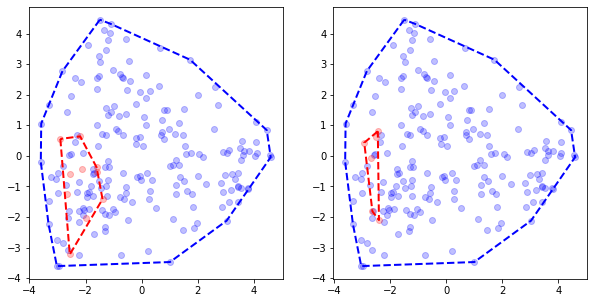

In [23]:
document_pts, summary_pts = project_pca(document_embs, summary_embs_np[m])

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
plot(ax1, document_pts, summary_pts[0], add_hull=True)

ax2 = fig.add_subplot(1,2,2)
plot(ax2, document_pts, summary_pts[1], add_hull=True)

### Matplotlib + t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 462 samples in 0.012s...
[t-SNE] Computed neighbors for 462 samples in 0.231s...
[t-SNE] Computed conditional probabilities for sample 462 / 462
[t-SNE] Mean sigma: 2.870281
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.516319
[t-SNE] KL divergence after 1850 iterations: 0.736734


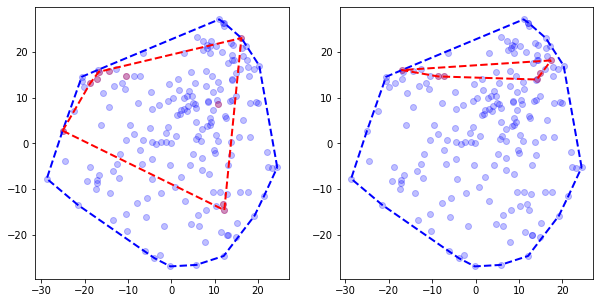

In [24]:
document_pts, summary_pts = project_tsne(document_embs, summary_embs_np[m])

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
plot(ax1, document_pts, summary_pts[0], add_hull=True)

ax2 = fig.add_subplot(1,2,2)
plot(ax2, document_pts, summary_pts[1], add_hull=True)

## Interactive plot

### Plotly + PCA

In [25]:
document_pts, summary_pts = project_pca(document_embs, summary_embs_np[m])

def make_df(pts, label):
    df = pd.DataFrame(pts, columns=['pca-0','pca-1'])
    df['label'] = label
    return df

df = pd.concat([make_df(document_pts, 'doc')] + \
               [make_df(summary_pts[i], f'sum-{i+1}') for i in range(len(summary_pts))], ignore_index=True)

In [26]:
@interact
def scatter_plot(label=df.label.unique()[1:]):
    df[df.label.isin(('doc',label))].iplot(kind='scatter',
                                           title=DATASET + ' - ' + TOPIC,
                                           x='pca-0',y='pca-1',
                                           mode='markers',
                                           categories='label',
                                           theme='solar',
                                           colorscale='set1')

interactive(children=(Dropdown(description='label', options=('sum-1', 'sum-2', 'sum-3', 'sum-4', 'sum-5', 'sum…

# Misc

## Extractive Summarization by Maximizing Semantic Volume

Paper: https://www.aclweb.org/anthology/D15-1228.pdf

In [27]:
def mask(N, idx):
    mask = np.ones(N, dtype=bool)
    mask[idx] = False
    return mask

N = len(document_embs_np)

R = document_embs_np
B = np.ndarray(shape=(0,R.shape[1]))
idx = []

c = R.sum(axis=0) / N

p = np.argmax(np.linalg.norm(R - c, axis=1))
idx.append(p)

q = np.argmax(np.linalg.norm(R - R[p], axis=1))
idx.append(q)

b_0 = R[q] / np.linalg.norm(R[q])
B = np.append(B, b_0.reshape(1,-1), axis=0)

L = 4
for i in range(L):
    r = np.argmax(np.apply_along_axis(distance_to_subspace, 1, R[mask(N, idx)], B))
    if r not in idx:
        idx.append(r)

        b_r = R[r] / np.linalg.norm(R[r])
        B = np.append(B, b_r.reshape(1,-1), axis=0)

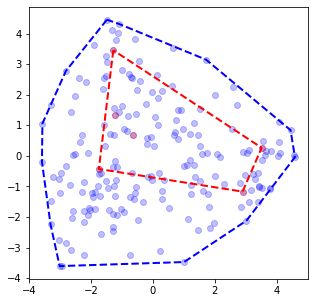

In [28]:
pca = PCA(n_components=2)
document_pts = pca.fit_transform(document_embs)

fig = plt.figure(figsize=(5,5))

ax1 = fig.add_subplot(1,1,1)
plot(ax1, document_pts, pca.transform(document_embs_np[idx]), add_hull=True)